## Import Libraries and Data

In [5]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_04-12-05-23.csv', firstRow=378, lastRow=384)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_050523_S379-384.csv',t_baseline=40,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [6]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=84s and ended at t=502s; mass=44.3155g
This equals a volume of 44.404m; expected was 44.48mL; error is 0.169%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0017500000000000003 g/s and for 2nd derivative = 0.0004375 g/s^2


<IPython.core.display.Javascript object>


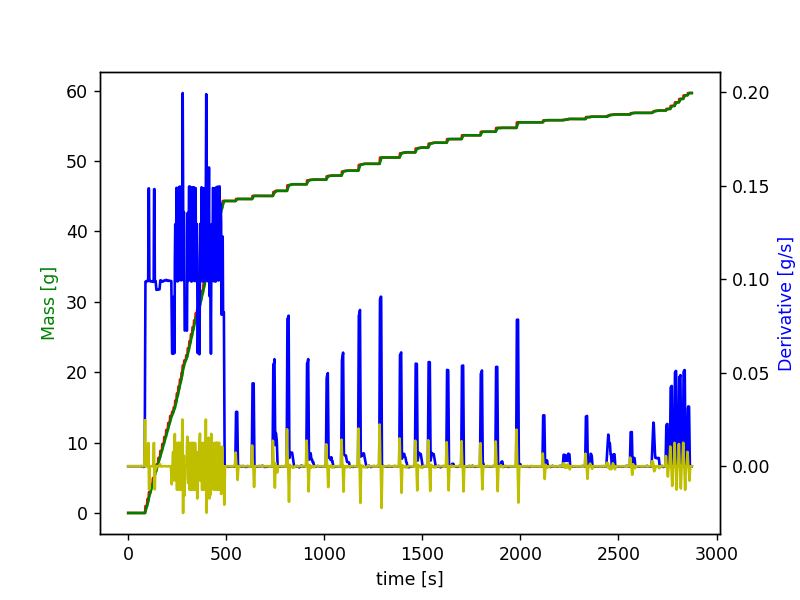

Addition of 0.288g Texapon SB 3 KC detected from 544s to 564s - expected volume = 0.582mL and actual volume = 0.259mL (resulting error is 55.414%)
Addition of 0.442g Texapon SB 3 KC detected from 628s to 648s - expected volume = 0.582mL and actual volume = 0.399mL (resulting error is 31.448%)
Addition of 0.724g Plantapon LC 7 detected from 734s to 766s - expected volume = 0.815mL and actual volume = 0.683mL (resulting error is 16.192%)
Addition of 0.936g Plantapon LC 7 detected from 806s to 848s - expected volume = 0.924mL and actual volume = 0.871mL (resulting error is 5.73%)
Addition of 0.667g Plantacare 818 detected from 906s to 950s - expected volume = 0.73mL and actual volume = 0.607mL (resulting error is 16.767%)
Addition of 0.578g Plantacare 2000 detected from 1006s to 1048s - expected volume = 0.594mL and actual volume = 0.528mL (resulting error is 11.085%)
Addition of 0.708g Plantacare 2000 detected from 1084s to 1132s - expected volume = 0.594mL and actual volume = 0.648mL (r

In [7]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.0025 g/s and for 2nd derivative = 0.000546875 g/s^2


<IPython.core.display.Javascript object>


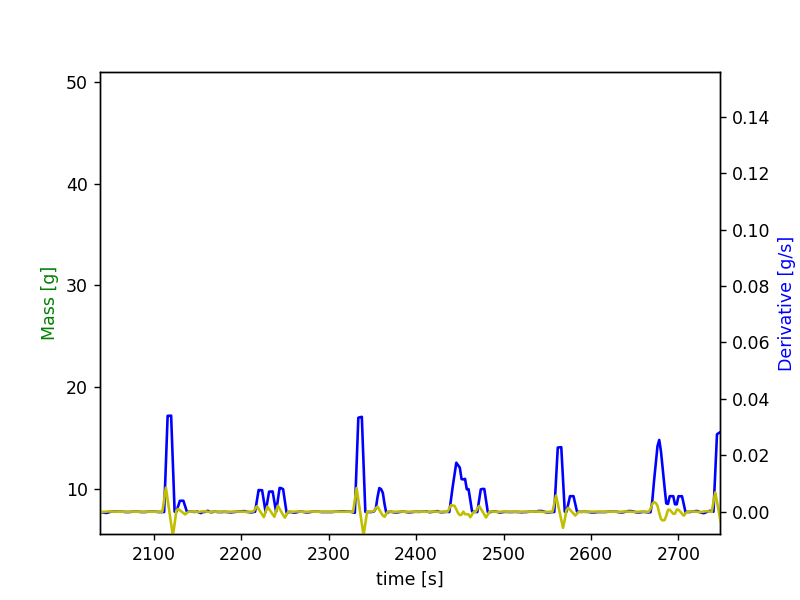

Addition of 0.302g Dehyquart CC7 Benz detected from 2110s to 2140s - expected volume = 0.269mL and actual volume = 0.298mL (resulting error is 10.76%)
Addition of 0.181g Dehyquart CC7 Benz detected from 2214s to 2256s - expected volume = 0.101mL and actual volume = 0.178mL (resulting error is 77.451%)
Addition of 0.328g Dehyquart CC7 Benz detected from 2328s to 2370s - expected volume = 0.263mL and actual volume = 0.319mL (resulting error is 21.481%)
Addition of 0.324g Dehyquart CC7 Benz detected from 2436s to 2486s - expected volume = 0.263mL and actual volume = 0.322mL (resulting error is 22.358%)
Addition of 0.225g Dehyquart CC7 Benz detected from 2556s to 2588s - expected volume = 0.177mL and actual volume = 0.222mL (resulting error is 25.208%)
Addition of 0.342g Dehyquart CC7 Benz detected from 2666s to 2712s - expected volume = 0.28mL and actual volume = 0.336mL (resulting error is 20.044%)


In [9]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=8, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


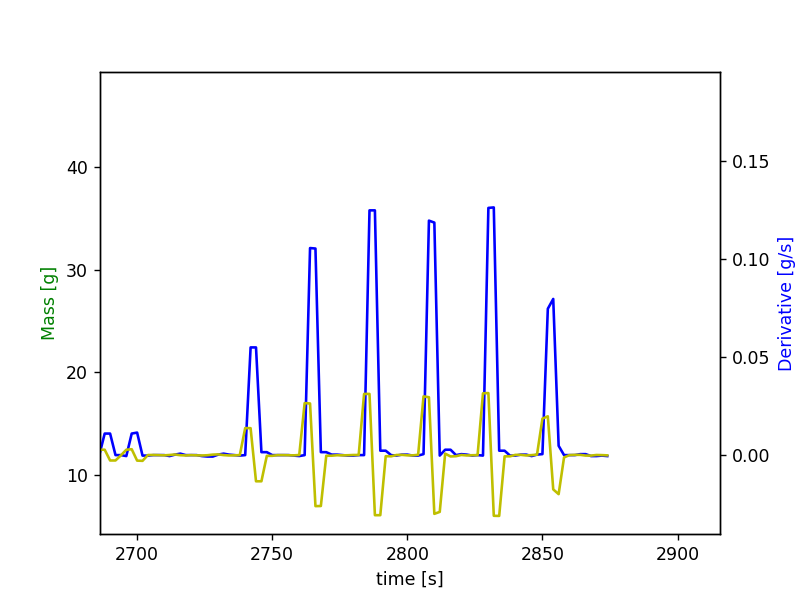

Addition of 0.226g Arlypon F detected from 2738s to 2750s - expected volume = 0.25mL and actual volume = 0.257mL (resulting error is 2.5%)
Addition of 0.428g Arlypon F detected from 2760s to 2772s - expected volume = 0.465mL and actual volume = 0.486mL (resulting error is 4.523%)
Addition of 0.508g Arlypon F detected from 2782s to 2794s - expected volume = 0.551mL and actual volume = 0.571mL (resulting error is 3.564%)
Addition of 0.487g Arlypon F detected from 2804s to 2816s - expected volume = 0.527mL and actual volume = 0.559mL (resulting error is 5.978%)
Addition of 0.513g Arlypon F detected from 2826s to 2838s - expected volume = 0.553mL and actual volume = 0.583mL (resulting error is 5.339%)
Addition of 0.319g Arlypon F detected from 2848s to 2862s - expected volume = 0.332mL and actual volume = 0.362mL (resulting error is 8.874%)


In [10]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [11]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_050523_S379-S384.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_21376\1402679324.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
378,379.0,0.000000,0.0,7.398269,0.000000,0.000000,0.0,0.000000,7.492267,0.000000,0.0,0.000000,0.000000,0.0,0.0,3.089423,0.0,2.303977,0.0
379,380.0,0.000000,0.0,0.000000,0.000000,12.643820,0.0,0.000000,0.000000,10.329834,0.0,0.000000,0.000000,0.0,0.0,1.779989,0.0,4.204117,0.0
380,381.0,0.000000,0.0,9.358242,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,7.889674,0.0,0.0,3.279033,0.0,5.083502,0.0
381,382.0,7.506877,0.0,0.000000,0.000000,9.976962,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,3.333021,0.0,5.011095,0.0
382,383.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,8.804648,13.420923,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.196776,0.0,5.000315,0.0
383,384.0,0.000000,0.0,0.000000,6.640148,0.000000,0.0,0.000000,0.000000,0.000000,0.0,10.633997,0.000000,0.0,0.0,3.407470,0.0,3.177152,0.0
